In [1]:
import numpy as np
import scipy as sp
from scipy import signal
import sklearn as sk
import preprocessing as pp
import utilities as u
from matplotlib import pyplot as plt
import pickle
import os
from scipy.interpolate import interp1d as spline
from sklearn.linear_model import HuberRegressor as hreg
from sklearn.linear_model import LinearRegression as lreg
from sklearn.decomposition import PCA as pca
from scipy.optimize import minimize
import UnityTransforms as ut
import SimilarityMatrixAnalysis as sm
import itertools


%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
df = pp.load_session_db(dir='D:\\')
# df = pp.load_session_db()
df = df[df['RewardCount']>40]
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
df = df[df["Track"]=="TwoTower_foraging"]

In [3]:
df_mouse = df[df["MouseName"]=='4343703.1']
df_mouse

,MouseName,DateFolder,SessionNumber,Track,RewardCount,Imaging,ImagingRegion,DateTime,data file,scanmat,s2pfolder
3557,4343703.1,14_03_2020,1,TwoTower_foraging,76,1,CA1,2020-03-14,D:\VR_Data\TwoTower\4343703.1\14_03_2020\TwoTo...,None,None
3593,4343703.1,16_03_2020,2,TwoTower_foraging,74,1,CA1,2020-03-16,D:\VR_Data\TwoTower\4343703.1\16_03_2020\TwoTo...,None,None
3634,4343703.1,18_03_2020,3,TwoTower_foraging,86,1,CA1,2020-03-18,D:\VR_Data\TwoTower\4343703.1\18_03_2020\TwoTo...,None,None
3665,4343703.1,20_03_2020,2,TwoTower_foraging,79,1,CA1,2020-03-20,D:\VR_Data\TwoTower\4343703.1\20_03_2020\TwoTo...,None,None
3688,4343703.1,21_03_2020,2,TwoTower_foraging,78,1,CA1,2020-03-21,D:\VR_Data\TwoTower\4343703.1\21_03_2020\TwoTo...,None,None
3703,4343703.1,22_03_2020,2,TwoTower_foraging,87,1,CA1,2020-03-22,D:\VR_Data\TwoTower\4343703.1\22_03_2020\TwoTo...,None,None


In [4]:
mice = ['4139265.3','4139265.4','4139265.5','4222168.1','4343703.1','4343706','4222153.1','4222153.2',
        '4222153.3','4222174.1','4222154.1','4343702.1']
first_sessions = [5,5,5,3,5,2,4,4,4,4,4,4]
print(len(mice),len(first_sessions))
rare_mice,freq_mice = mice[:6],mice[6:]
rare_fs, freq_fs = first_sessions[:6],first_sessions[6:]


12 12


In [5]:
def single_session_data(sess):

    VRDat = pp.behavior_dataframe(sess["data file"])
    trial_info, tstarts_, teleports_ = u.by_trial_info(VRDat)
    return trial_info['morphs'][:,np.newaxis]+trial_info['wallJitter'][:,np.newaxis]

def single_mouse_data(mouse,df_mouse):

    data = {}
    for i in range(df_mouse.shape[0]):
        sess = df_mouse.iloc[i]
        date, num = sess['DateFolder'],sess['SessionNumber']
        key = date + str(num) 
        
        data[key] = single_session_data(sess)
        
    return data

def single_mouse_em_all(mouse,data = None):
    if data is None:
        data = single_mouse_data(mouse,df[df["MouseName"]==mouse])
    else:
        pass
    
    for i, (key,arr) in enumerate(data.items()):
        if i == 0:
            em_all = arr
        else:
            em_all = np.concatenate((em_all,arr),axis=0)
    return em_all


In [6]:
def single_mouse_simmat(mouse,df,first_ind=5,sigma_prior=.1,sigma_likelihood=.3,
                              x = np.linspace(-.3,1.3,num=1000)[np.newaxis,:],
                               mus = np.linspace(-.3,1.3,num=1000)[:,np.newaxis],
                              plot=False):
    
    behav_sessions = df[df["MouseName"]==mouse]
    imag_sessions = behav_sessions[behav_sessions["Imaging"]==1]
    imag_sessions = imag_sessions[(imag_sessions['ImagingRegion']=='CA1' )|(imag_sessions['ImagingRegion']=='')]
    morph_data = single_mouse_data(mouse,behav_sessions)
    
    WALLMORPH,C_mats,RTSF=[],[],[]
    
    morphbins = np.linspace(-.11,1.11,num=11)
    for ind in range(first_ind,imag_sessions.shape[0]):
        sess = imag_sessions.iloc[ind]
        
        print(ind)
        # calculate cumulative prior up to current session
        date_folder,sessn = None,-np.inf
        em_all = None
        b_ind = 0
        while date_folder!=sess['DateFolder'] or sessn<sess["SessionNumber"]:
            b_sess = behav_sessions.iloc[b_ind]
            date_folder = b_sess['DateFolder']
            sessn = b_sess['SessionNumber']
            if em_all is None:
                em_all = morph_data[date_folder+str(sessn)]
            else:
                em_all = np.concatenate((em_all,morph_data[date_folder+str(sessn)]),axis=0)
            b_ind+=1


        # load data
        with open(os.path.join("D:\\Suite2P_Data\\",sess["MouseName"],"%s_%s_%i.pkl" % (sess["Track"],sess["DateFolder"],sess["SessionNumber"])),'rb') as f:
            data = pickle.load(f)
        VRDat,S = data['VRDat'],data['S']
        S[np.isnan(S)]=0
        S = S/np.percentile(S,95,axis=0)
        trial_info,S_trial_mat= data['trial_info'],data['S_trial_mat']
        morphs = trial_info['morphs']+trial_info['wallJitter']
        WALLMORPH.append(morphs)
#         morphdig = np.digitize(morphs,morphbins)-1
        
        S_trial_mat[np.isnan(S_trial_mat)]=0
#         S_trial_mat_bin = np.zeros((5,*S_trial_mat.shape[1:]))
#         for i,m in enumerate([0.,.25,.5,.75,1.]):
#             S_trial_mat_bin[i,:,:]=S_trial_mat[trial==i,:,:].mean(axis=0)
        
        
#         S_tmat_norm = np.copy(S_trial_mat_bin).reshape(S_trial_mat_bin.shape[0],-1)
        S_tmat_norm = np.copy(S_trial_mat).reshape(S_trial_mat.shape[0],-1)
        S_tmat_norm = S_tmat_norm/np.linalg.norm(S_tmat_norm,ord=2,axis=-1,keepdims=True)
        C = np.matmul(S_tmat_norm,S_tmat_norm.T)
        C[np.diag_indices_from(C)]=np.nan
#         C_mats.append(C)
        _C = np.zeros((5,5))
#         print(morphdig.shape,C.shape)
        for i,m in enumerate([0,.25,.5,.75,1.]):
            for j,mm in enumerate([0,.25,.5,.75,1.]):
                __C = C[trial_info['morphs']==m,:]
                __C = __C[:,trial_info['morphs']==mm]
                _C[i,j] = np.nanmean(__C)
        C_mats.append(_C)
        
        # similarity fraction
        rtsf = u.rt_similarity_fraction(S_trial_mat,trial_info)
#         S_trial_mat_norm = S_trial_mat_bin/np.linalg.norm(S_trial_mat_bin,ord=2,axis=-1,keepdims=True)
#         rtsf = np.zeros((10,S_trial_mat_norm.shape[1]))
        
#         for i in range(10):
        _rtsf = np.zeros((5,rtsf.shape[1]))
        for i,m in enumerate([0,.25,.5,.75,1.]):
#             rtsf[i,:] = np.diagonal(np.matmul(S_trial_mat_norm[i,:,:],S_trial_mat_norm[i,:,:].T))
            _rtsf[i,:] = rtsf[trial_info['morphs']==m,:].mean(axis=0)
        RTSF.append(_rtsf)
#         RTSF.append(rtsf)
       
    return {'wallmorph':WALLMORPH, 'C':C_mats,'RTSF':RTSF}
       

0.8237291881754005
0.3878967525794292
0.3017454334669003
0.30007366748181774
0.296553850302658
0.2737197070443221
0.27776684440248123
0.24362545512939504


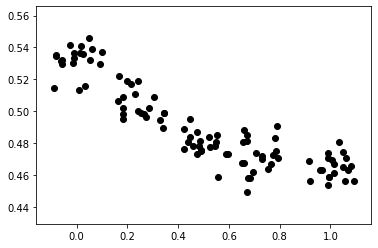

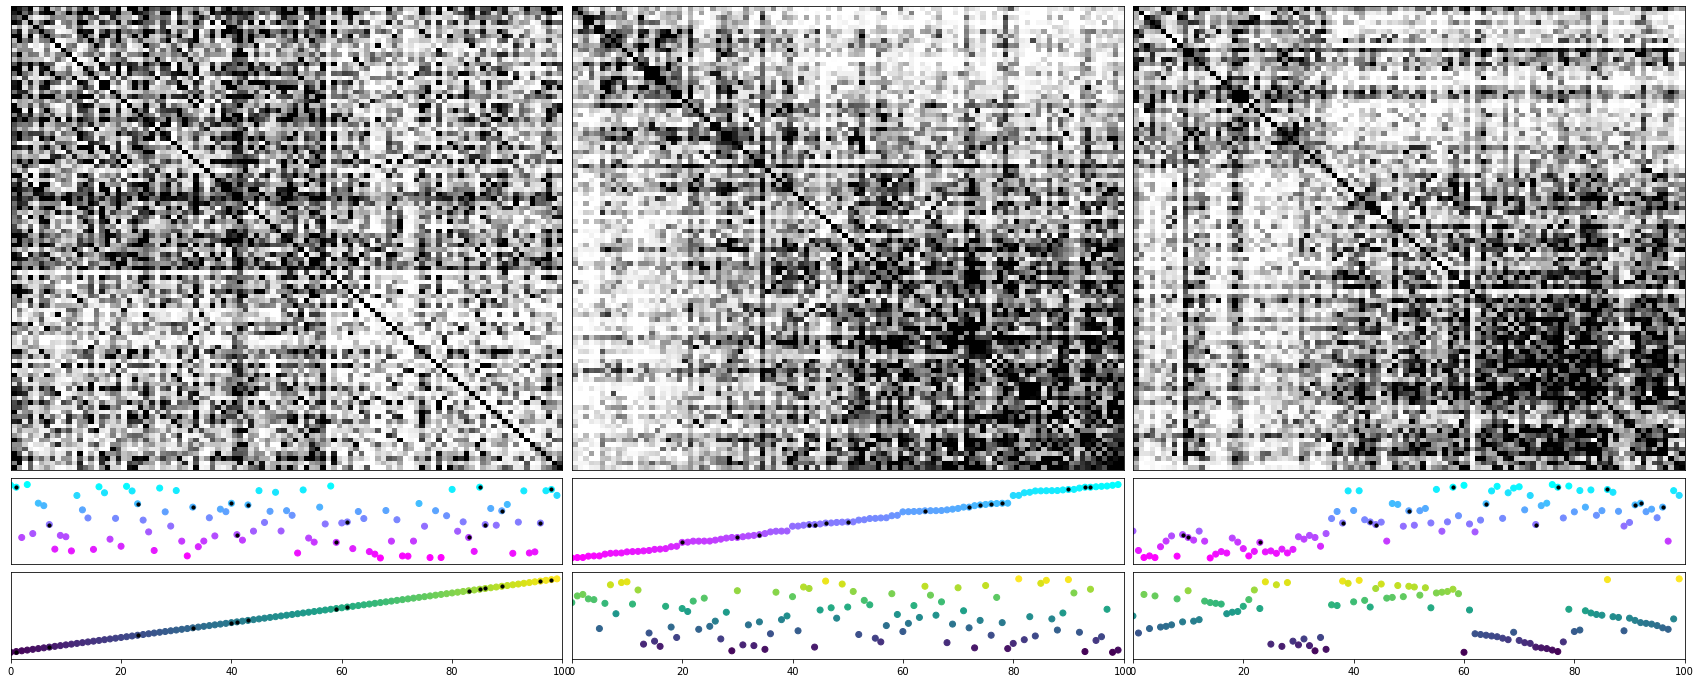

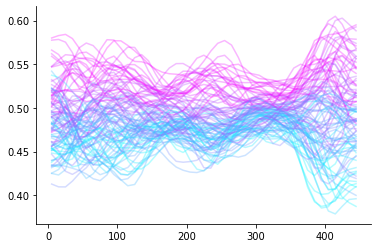

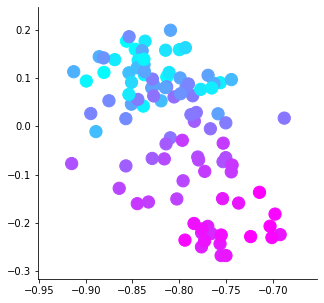

In [26]:
#### example 

df_mouse = df[df['MouseName']=='4343702.1']
sess = df_mouse.iloc[1]


with open(os.path.join("D:\\Suite2P_Data\\",sess["MouseName"],"%s_%s_%i.pkl" % (sess["Track"],sess["DateFolder"],sess["SessionNumber"])),'rb') as f:
            data = pickle.load(f)
VRDat,S = data['VRDat'],data['S']
S[np.isnan(S)]=0
S = S/np.percentile(S,95,axis=0)
trial_info,S_trial_mat= data['trial_info'],data['S_trial_mat']
effMorph = trial_info['morphs']+trial_info['wallJitter']
effMorph = (effMorph +.1)/1.2
S_trial_mat[np.isnan(S_trial_mat)]=0

# similarity fraction
sf = u.similarity_fraction(S_trial_mat,trial_info)
f,ax = plt.subplots()
ax.scatter(effMorph*1.2-.1,1-sf,color='black') #,c=plt.cm.cool(1-effMorph))
# ax.set_ylim([.7,.3])
f.savefig("D:\\Morph_Results\\figures\\ExampleSimMats\\%s_%s_%i_sf.pdf" % (sess["MouseName"],sess["DateFolder"],sess["SessionNumber"]),format="pdf")

S_tmat_norm = np.copy(S_trial_mat).reshape(S_trial_mat.shape[0],-1)
S_tmat_norm = S_tmat_norm/np.linalg.norm(S_tmat_norm,ord=2,axis=-1,keepdims=True)
C = np.matmul(S_tmat_norm,S_tmat_norm.T)

f, [[c_ax,m_ax,t_ax],[cm_ax,mm_ax,tm_ax],[cc_ax,mc_ax,tc_ax]] = sm.plot_trial_simmat(np.minimum(C,1-1E-10),trial_info)
f.savefig("D:\\Morph_Results\\figures\\ExampleSimMats\\%s_%s_%i_sm.pdf" % (sess["MouseName"],sess["DateFolder"],sess["SessionNumber"]),format="pdf")


rtsf = u.rt_similarity_fraction(S_trial_mat,trial_info)

f,ax = plt.subplots()
for t in range(rtsf.shape[0]):
    ax.plot(np.arange(5,450,10),1-rtsf[t,:],alpha=.3,c=plt.cm.cool(1-effMorph[t]))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_ylim([.8,.2])
f.savefig("D:\\Morph_Results\\figures\\ExampleSimMats\\%s_%s_%i_rtsf.pdf" % (sess["MouseName"],sess["DateFolder"],sess["SessionNumber"]),format="pdf")


[w,V]=np.linalg.eig(C)
order = np.argsort(w)[::-1]
w = w[order]
V=V[:,order]
# project trials onto top 3 eigenvectors
X =  np.matmul(C,V[:,:3])
f_embed ,ax_embed= plt.subplots(figsize=[5,5])
ax_embed.scatter(X[:,0],X[:,1],c=1-effMorph,cmap='cool',marker='o',s=150)
ax_embed.spines['top'].set_visible(False)
ax_embed.spines['right'].set_visible(False)
f_embed.savefig("D:\\Morph_Results\\figures\\ExampleSimMats\\%s_%s_%i_eig.pdf" % (sess["MouseName"],sess["DateFolder"],sess["SessionNumber"]),format="pdf")

In [7]:
rare_simmats = {mouse:single_mouse_simmat(mouse,df,first_ind=fs) for (mouse,fs) in zip(rare_mice,rare_fs)}
freq_simmats = {mouse:single_mouse_simmat(mouse,df,first_ind=4) for mouse in freq_mice}

C:\Users\markp\anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


5
6
7
8
9
5
6
7
8
9
10
5
6
7
8
9
3
4
5
6
5
2
3
4
4
5
6
4
5
6
7
4
4
5
6
7
8
4
5
6
7
8
4
5
6


(5, 5, 5)
(6, 5, 5)
(5, 5, 5)
(4, 5, 5)
(1, 5, 5)
(3, 5, 5)
922


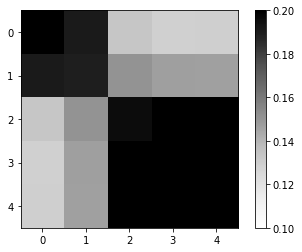

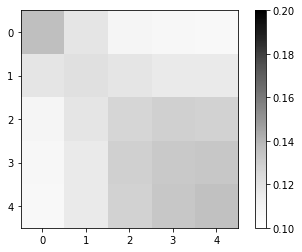

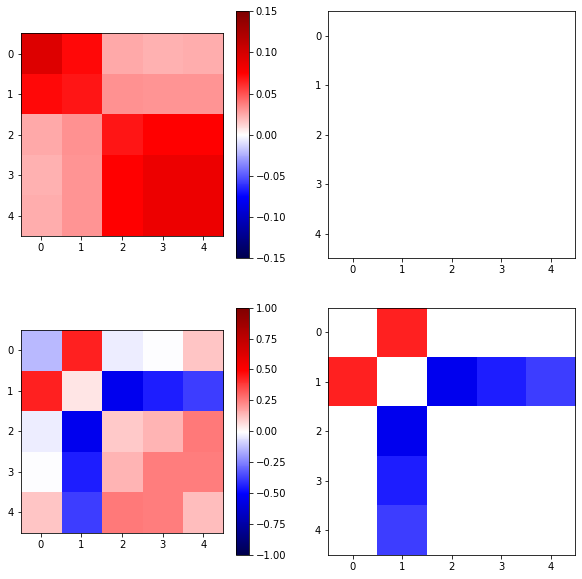

In [8]:
C_all,C_all_n = {},{}
C_rare,C_rare_n = 0,0
den = 0
for m, res in rare_simmats.items():
    print(np.array(res['C']).shape)
#     C_tmp = np.array(res['C']).mean(axis=0)
    C_all[m]= np.copy(np.array(res['C']).mean(axis=0)) #np.array(res['C']).mean(axis=0)
    C_rare+=np.copy(np.array(res['C']).mean(axis=0))
                      
                      
    C_tmp_n = 0
    for _C in res['C']:
#         _C /= np.copy(_C).ravel().mean()# (np.copy(_C)-np.nanmean(_C.ravel()))/np.nanstd(_C.ravel())
#         C_tmp_n+= np.copy(_C)/_C.ravel().mean()
        C_tmp_n+= (np.copy(_C)-_C.ravel().mean())/np.std(_C.ravel())
    C_tmp_n/=len(res['C'])
#     C_tmp_n = (C_tmp-np.nanmean(C_tmp.ravel()))/np.nanstd(C_tmp.ravel())
    
    
    C_rare_n += C_tmp_n
    
    
    C_all_n[m]=np.copy(C_tmp_n)
    den+=1 #len(res['C'])

    
C_rare/=den
C_rare_n/=den
# C_rare_n=(C_rare-np.nanmean(C_rare.ravel()))/np.nanstd(C_rare.ravel())
f,ax = plt.subplots()
im = ax.imshow(C_rare,cmap='Greys',vmin=.1,vmax=.2)
f.colorbar(im)
f.savefig("D:\\Morph_Results\\figures\\rare_mean_sm.pdf",format="pdf")



C_freq,C_freq_n = 0,0
den = 0
for m, res in freq_simmats.items():
#     C_tmp = np.array(res['C']).mean(axis=0)
    C_all[m]= np.copy(np.array(res['C']).mean(axis=0)) #np.array(res['C']).mean(axis=0)
    C_freq+=np.copy(np.array(res['C']).mean(axis=0))

    C_tmp_n = 0
    for _C in res['C']:
#         _C /= np.copy(_C).ravel().mean() #(np.copy(_C)-np.nanmean(_C.ravel()))/np.nanstd(_C.ravel())
#         C_tmp_n+=np.copy(_C)/_C.ravel().mean()
        C_tmp_n+= (np.copy(_C)-_C.ravel().mean())/np.std(_C.ravel())
    C_tmp_n/=len(res['C'])
    
#     C_freq+=C_tmp #np.array(res['C']).mean(axis=0)
    C_freq_n+=C_tmp_n
    
#     C_all[m]=np.copy(C_tmp) #np.array(res['C']).mean(axis=0)
    C_all_n[m]=np.copy(C_tmp_n)
    den+=1 #len(res['C'])
C_freq/=den
C_freq_n/=den
# C_freq[np.diag_indices(5)]=np.nan
# C_freq_n = (C_freq-np.nanmean(C_freq.ravel()))/np.nanstd(C_freq.ravel())
f,ax = plt.subplots()
im = ax.imshow(C_freq,cmap='Greys',vmin=.1,vmax=.2)
f.colorbar(im)
f.savefig("D:\\Morph_Results\\figures\\freq_mean_sm.pdf",format="pdf")


f,ax = plt.subplots(2,2,figsize=[10,10])
im = ax[0,0].imshow(C_rare-C_freq,cmap='seismic',vmin=-.15,vmax=.15)
C_rand_n = []
C_rand=[]
a =0 
for c, comb in enumerate(itertools.combinations(mice,6)):
    if (set(comb) != set(mice[:6])) and (set(comb) != set(mice[6:])):
        a+=1
#         print(comb,mice[:6])
#         print([m for m in comb],[m for m in mice if m not in comb])
        C0,C1 = np.array([C_all[m] for m in comb]).mean(axis=0), np.array([C_all[m] for m in mice if m not in comb]).mean(axis=0)
        C_rand.append(C0-C1)
#         C0 = (C0-np.nanmean(C0.ravel()))/np.nanstd(C0.ravel())
#         C1 = (C1-np.nanmean(C1.ravel()))/np.nanstd(C1.ravel())
        C0,C1 = np.array([C_all_n[m] for m in comb]).mean(axis=0), np.array([C_all_n[m] for m in mice if m not in comb]).mean(axis=0)
        C_rand_n.append(C0-C1)
print(a)
C_rand=np.array(C_rand)
C_min = np.percentile(C_rand,2.5,axis=0)
C_max = np.percentile(C_rand,97.5,axis=0)
f.colorbar(im,ax=ax[0,0])
diff = C_rare-C_freq
mask = (diff<=C_min) | (diff>=C_max)
diff[~mask]=np.nan
ax[0,1].imshow(diff,cmap='seismic',vmin=-.15,vmax=.15)


im = ax[1,0].imshow(C_rare_n-C_freq_n,vmin=-1,vmax=1,cmap='seismic')
C_rand_n = np.array(C_rand_n)
C_min = np.percentile(C_rand_n,2.5,axis=0)
C_max = np.percentile(C_rand_n,97.5,axis=0)
f.colorbar(im,ax=ax[1,0])
diff = C_rare_n-C_freq_n
mask = (diff<=C_min) | (diff>=C_max)
diff[~mask]=np.nan
ax[1,1].imshow(diff,cmap='seismic',vmin=-1,vmax=1)

f.savefig("D:\\Morph_Results\\figures\\rareVfreq_mean_sm.pdf",format="pdf")

In [ ]:



rtsf_rare = []
den = 0
for m, res in rare_simmats.items():
    print(np.array(res['RTSF']).shape)
    
    rtsf_rare.append(np.copy(np.array(res['RTSF'])).mean(axis=0)[np.newaxis,:,:])
rtsf_rare = np.concatenate(rtsf_rare)
print(rtsf_rare.shape)
f,ax = plt.subplots(1,2,figsize=[20,5])
f.subplots_adjust(wspace=.5)
for m, morph in enumerate([0,.25,.5,.75,1]):
    mu,sem = rtsf_rare[:,m,:].mean(axis=0), sp.stats.sem(rtsf_rare[:,m,:],axis=0)
    ax[0].fill_between(np.arange(5,450,10),1-mu-sem,1-mu+sem,color=plt.cm.cool(np.float(1-morph)))
    
rtsf_freq = []
den = 0
for m, res in freq_simmats.items():
    print(np.array(res['RTSF']).shape)
    
    rtsf_freq.append(np.copy(np.array(res['RTSF'])).mean(axis=0)[np.newaxis,:,:])
rtsf_freq = np.concatenate(rtsf_freq)
print(rtsf_freq.shape)
for m, morph in enumerate([0,.25,.5,.75,1]):
    mu,sem = rtsf_freq[:,m,:].mean(axis=0), sp.stats.sem(rtsf_freq[:,m,:],axis=0)
    ax[1].fill_between(np.arange(5,450,10),1-mu-sem,1-mu+sem,color=plt.cm.cool(np.float(1-morph)))
    
    

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

f.savefig("D:\\Morph_Results\\figures\\mouseMean_rtsf.pdf",format="pdf")

(5, 5, 45)
(6, 5, 45)
(5, 5, 45)
(4, 5, 45)
(1, 5, 45)
(3, 5, 45)
(6, 5, 45)
(3, 5, 45)
(4, 5, 45)
(1, 5, 45)
(5, 5, 45)
(5, 5, 45)
(3, 5, 45)
(6, 5, 45)
